In [1]:
#@markdown #Image Processing - 67829. { display-mode: "form" }
#@markdown ##Exercise 5:  Deep Style Image Prior
#@markdown ##Due date: 13.01.2022 at 23:59
#@title{ display-mode: "form" }

#@markdown
#@markdown This exercise is a bit different than the rest of the exercises in the course.
#@markdown The submissions will be a PDF file with your answers and results to the exercise 
#@markdown as well as some files so that we can verify the authenticity of your results.
#@markdown This notebook provides the basic code, but you do not need to adhere to some specific API 
#@markdown and we will not be running unit tests on your code. 
#@markdown We will however, be going over your code and running it manually. 
#@markdown Moreover, we will be running tests to ensure the authenticity of your solution and detect plagiarism
#@markdown
#@markdown
#@markdown Before you start working on the exercise it is recommended that you review the lecture slides covering neural networks,
#@markdown
#@markdown 
#@markdown **NOTE**: Neural networks are typically trained on GPUs, without GPUs training takes much longer. 
#@markdown To enable GPU tranining click on "Runtime" -> "Change runtime type" -> "GPU" -> "SAVE".
#@markdown
#@markdown **NOTE**: A short guide on debugging your code using colab is availble [here](https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/01.06-Errors-and-Debugging.ipynb#scrollTo=qnIn-rWFqoww).

#@markdown But first, we have to download all of the dependencies and install them.
#@markdown Play this cell to download it and get everything ready. markdown This may take a few minutes.

 
!mkdir impr_ex5_resources
%cd impr_ex5_resources
#!wget "https://www.cs.huji.ac.il/~impr/shape_predictor_68_face_landmarks.dat" -O shape_predictor_68_face_landmarks.dat 
#!wget "https://www.cs.huji.ac.il/~impr/align_faces.py" -O align_faces.py 
!wget "https://www.cs.huji.ac.il/~impr/stylegan2-ada-pytorch.tar" -O stylegan2-ada-pytorch.tar
!tar -xvf stylegan2-ada-pytorch.tar
!rm -f stylegan2-ada-pytorch.tar

import sys
ROOT_PATH="/content/impr_ex5_resources/stylegan2-ada-pytorch"
sys.path.append(ROOT_PATH)


!pip install ninja
!pip install mediapy
CHECKPOINTS_PATH = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"



import copy
import os
from time import perf_counter
import click
import imageio
import numpy as np
import PIL.Image
import torch
import torch.nn.functional as F

import dnnlib
import legacy
import numpy as np
from skimage.draw import line
from torch.nn.functional import conv2d,conv1d
import mediapy as media
from IPython.display import clear_output



mkdir: cannot create directory ‘impr_ex5_resources’: File exists
/content/impr_ex5_resources
--2022-01-18 08:31:02--  https://www.cs.huji.ac.il/~impr/stylegan2-ada-pytorch.tar
Resolving www.cs.huji.ac.il (www.cs.huji.ac.il)... 132.65.118.16
Connecting to www.cs.huji.ac.il (www.cs.huji.ac.il)|132.65.118.16|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://www.cs.huji.ac.il/w~impr/stylegan2-ada-pytorch.tar [following]
--2022-01-18 08:31:03--  https://www.cs.huji.ac.il/w~impr/stylegan2-ada-pytorch.tar
Reusing existing connection to www.cs.huji.ac.il:443.
HTTP request sent, awaiting response... 200 OK
Length: 100364800 (96M) [application/x-tar]
Saving to: ‘stylegan2-ada-pytorch.tar’

stylegan2-ada-pytor 100%[===================>]  95.71M  17.2MB/s    in 6.8s    

2022-01-18 08:31:10 (14.1 MB/s) - ‘stylegan2-ada-pytorch.tar’ saved [100364800/100364800]

stylegan2-ada-pytorch/
stylegan2-ada-pytorch/metrics/
stylegan2-ada-pytorch/._dataset_tool

In [2]:
#@markdown **NOTE**: It is strongly advised you save your results to Google 
#@markdown Drive as they will be deleted from Colab once it restarts. 
#@markdown To connect Google Drive run this cell. 
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
GAUSSIAN_BLUR_DEGRADATION= 'GAUSSIAN_BLUR_DEGRADATION'
GRAYSCALE_DEGRADATION = 'GRAYSCALE_DEGRADATION'
INPAINTING_DEGRADATION = 'INPAINTING_DEGRADATION'
DENOISING_DEGRADATION = 'DENOISING_DEGRADATION'
NO_DEGRADATION= 'NO_DEGRADATION'


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
   import scipy.io.wavfile
   from scipy import signal
   import torchvision.transforms
   from PIL import ImageOps
   from imageio import imread
   from skimage.color import rgb2gray, rgba2rgb

   def blur(im):
     kernel_size = 100

     filter_vec = np.float64(np.ones((1, 2)))
     # create filter vector
     while filter_vec.shape[1] != kernel_size:
       filter_vec = scipy.signal.convolve2d(filter_vec, np.ones((1, 2)))
     # normalize filter vector
     sum_vec = np.sum(filter_vec)
     filter_vec = filter_vec / sum_vec

     filter_tensor = torch.from_numpy(filter_vec)
     filter_tensor = filter_tensor.to(torch.device("cuda")).to(torch.float32)
     filter_tensor = torch.reshape(filter_tensor, (1, filter_tensor.size(dim=0), filter_tensor.size(dim=1)))
     filter_tensor = filter_tensor.unsqueeze(0).repeat(3,1,1,1)
     
     im = torch.nn.functional.conv2d(im, filter_tensor, padding='same', groups=3)
     im = torch.nn.functional.conv2d(im, filter_tensor.permute(0, 1, 3 ,2), padding='same', groups=3)

     return im
  
   def grayscale(im):
     return torchvision.transforms.Grayscale(3)(im)
  
   def inpainting(im):
     # Load mask image.
     mask_fname = "/content/drive/MyDrive/ex5_impr/fei_fei_li_inpainting_mask.png"
     mask = torch.tensor(rgb2gray(rgba2rgb(imread(mask_fname) / 255))).to(torch.device("cuda"))

     return im * mask

In [11]:
def run_latent_optimization(outdir,
    degradation_mode,
    G,
    imgs_to_disply_dict,
    target: torch.Tensor, # [C,H,W] and dynamic range [0,255], W & H must match G output resolution
    *,
    num_steps                  = 1000,
    w_avg_samples              = 10000,
    initial_learning_rate      = 0.1,
    initial_noise_factor       = 0.05,
    lr_rampdown_length         = 0.25,
    lr_rampup_length           = 0.05,
    noise_ramp_length          = 0.75,
    regularize_noise_weight    = 1e5,
    latent_dist_reg_weight     = 0.001,
    device: torch.device
    
):
    assert target.shape == (G.img_channels, G.img_resolution, G.img_resolution)

    G = copy.deepcopy(G).eval().requires_grad_(False).to(device) # type: ignore
  
    # Compute w stats.
    print(f'Computing W midpoint and stddev using {w_avg_samples} samples...')
    z_samples = np.random.RandomState(123).randn(w_avg_samples, G.z_dim)
    w_samples = G.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C]
    w_samples = w_samples.cpu().numpy().astype(np.float32)
    w_avg = np.mean(w_samples, axis=0, keepdims=True)      # [1, 18, C]
    w_avg_original = torch.from_numpy(w_avg).to(device).float()
    w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5

    # Setup noise inputs.
    noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }

    # Load VGG16 feature detector.
    url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
    with dnnlib.util.open_url(url) as f:
        vgg16 = torch.jit.load(f).eval().to(device)
    
    # Features for target image.
    target_images = target.unsqueeze(0).to(device).to(torch.float32)

    

    if target_images.shape[2] > 256:
        target_images = F.interpolate(target_images, size=(256, 256), mode='area')
    target_features = vgg16(target_images, resize_images=False, return_lpips=True)

    w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) 
    w_out = torch.zeros([num_steps] + list(w_opt.shape[1:]), dtype=torch.float32, device=device)
    optimizer = torch.optim.Adam([w_opt] + list(noise_bufs.values()), betas=(0.9, 0.999), lr=initial_learning_rate)
    
    # Init noise.
    for buf in noise_bufs.values():
        buf[:] = torch.randn_like(buf)
        buf.requires_grad = True

    loss_array = []

    for step in range(num_steps):
        # Learning rate schedule.
        t = step / num_steps
        w_noise_scale = w_std * initial_noise_factor * max(0.0, 1.0 - t / noise_ramp_length) ** 2
        lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
        lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
        lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
        lr = initial_learning_rate * lr_ramp
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # Synth image from opt_w
        w_noise = torch.randn_like(w_opt) * w_noise_scale
        ws = w_opt + w_noise
        synth_images = G.synthesis(ws, noise_mode='const')
        
        # Prep to save synth image
        synth_image_save = (synth_images + 1) * (255/2)
        synth_image_save = synth_image_save.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

    
        # ********************************************************************************************************
        # ******************                   NEED TO FILL IN THE FOLLOWING CODE               ******************
        # ********************************************************************************************************
        if  degradation_mode == INPAINTING_DEGRADATION:
          synth_images = inpainting(synth_images)
        elif degradation_mode == GRAYSCALE_DEGRADATION:
          synth_images = grayscale(synth_images)
        elif degradation_mode == GAUSSIAN_BLUR_DEGRADATION:
          synth_images = blur(synth_images)
        # ********************************************************************************************************
        # ******************                          END CODE TO ADD SECTION                   ******************
        # ********************************************************************************************************
         
        
        # Prep to save and show images
        synth_image_degraded_save = (synth_images + 1) * (255/2)
        synth_image_degraded_save = synth_image_degraded_save.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()  
     
        if step % 20 == 0:
          imgs_to_disply_dict["Generated Image"]=synth_image_save
          imgs_to_disply_dict["Generated Degraded Image"]=synth_image_degraded_save
          clear_output(wait=True)
          media.show_images(imgs_to_disply_dict,height=256)
        if step % 100 == 0:
          PIL.Image.fromarray(synth_image_save, 'RGB').save(f'{outdir}/intermidiate_%d_not_degraded.png'%step)
          PIL.Image.fromarray(synth_image_degraded_save, 'RGB').save(f'{outdir}/intermidiate_%d_degraded.png'%step)


        # Noise regularization.
        reg_loss = 0.0
        for v in noise_bufs.values():
            noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)

        # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
        synth_images = (synth_images + 1) * (255/2)
        if synth_images.shape[2] > 256:
            synth_images = F.interpolate(synth_images, size=(256, 256), mode='area')

        # Features for synth images.
        synth_features = vgg16(synth_images, resize_images=False, return_lpips=True)
        
        # Compute loss
        percep_loss = (target_features - synth_features).square().sum()
        latent_dist_reg = F.l1_loss(w_avg_original, w_opt)
        loss = percep_loss + reg_loss * regularize_noise_weight  + latent_dist_reg_weight * latent_dist_reg


        # Step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        print(f'step {step+1:>4d}/{num_steps}: percep_loss {percep_loss:<4.2f} latent_dist_reg {latent_dist_reg:<4.2f} loss {float(loss):<5.2f}' )
        loss_array.append(loss)
        # Save inverted latent for each optimization step.
        w_out[step] = w_opt.detach()[0]

        # Normalize noise.
        with torch.no_grad():
            for buf in noise_bufs.values():
                buf -= buf.mean()
                buf *= buf.square().mean().rsqrt()
    # plot of the optimization loss
    plt.plot(torch.range(1, num_steps), loss_array)
    plt.yscale('log')
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.show()
    return w_out

In [7]:
import matplotlib.pyplot as plt
def invert_image(degradation_mode,
                   target_fname,
                   outdir,
                   seed=303,
                   num_steps=1000,
                   latent_dist_reg_weight=0.001):
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Load networks.
    print('Loading networks from "%s"...' % CHECKPOINTS_PATH)
    device = torch.device('cuda')
    with dnnlib.util.open_url(CHECKPOINTS_PATH) as fp:
        networks = legacy.load_network_pkl(fp)
        G = networks['G_ema'].requires_grad_(False).to(device)
        

    # Load target image.
    if not os.path.exists(outdir):
      os.makedirs(outdir)
    target_pil = PIL.Image.open(target_fname).convert('RGB')
    w, h = target_pil.size
    s = min(w, h)
    target_pil = target_pil.crop(((w - s) // 2, (h - s) // 2, (w + s) // 2, (h + s) // 2))
    target_pil = target_pil.resize((G.img_resolution, G.img_resolution), PIL.Image.LANCZOS)
    target_uint8 = np.array(target_pil, dtype=np.uint8)
    target=torch.tensor(target_uint8.transpose([2, 0, 1]), device=device), 
    target_images = target[0].unsqueeze(0).to(device).to(torch.float32)

    # ********************************************************************************************************
    # ******************                   NEED TO FILL IN THE FOLLOWING CODE               ******************
    # ********************************************************************************************************
    if  degradation_mode == INPAINTING_DEGRADATION:
      target = inpainting(target_images)
      target_images = target
    elif degradation_mode == GRAYSCALE_DEGRADATION:
      target = grayscale(target_images)
      target_images = target
    elif degradation_mode == GAUSSIAN_BLUR_DEGRADATION:
      if target_fname != "/content/drive/MyDrive/ex5_impr/yann_lecun_blur.png":
        target = blur(target_images)
        target_images = target
    # ********************************************************************************************************
    # ******************                          END CODE TO ADD SECTION                   ******************
    # ********************************************************************************************************

    #Save target image
    target_to_save = target_images.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    PIL.Image.fromarray(target_to_save, 'RGB').save(f'{outdir}/original_degraded_image.png')
    imgs_to_disply_dict = {
        "Original Image":target_uint8,
        "Original Degraded Image":target_to_save,
              }

    # Run latent optimization
    start_time = perf_counter()
    optimization_steps = run_latent_optimization(
        outdir,
        degradation_mode,
        G,
        imgs_to_disply_dict,
        target[0],
        num_steps=num_steps,
        device=device,
        latent_dist_reg_weight=latent_dist_reg_weight
    )

    print (f'Elapsed: {(perf_counter()-start_time):.1f} s')
    os.makedirs(outdir, exist_ok=True)

    # Save final inverted image and latent vector.
    inverted_latent = optimization_steps[-1]
    synth_image = G.synthesis(inverted_latent.unsqueeze(0), noise_mode='const')
    synth_image = (synth_image + 1) * (255/2)
    synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    PIL.Image.fromarray(synth_image, 'RGB').save(f'{outdir}/final_inverted_image.png')
    np.savez(f'{outdir}/inverted_latent.npz', latent=inverted_latent.unsqueeze(0).cpu().numpy())

Original Image,Original Degraded Image,Generated Image,Generated Degraded Image

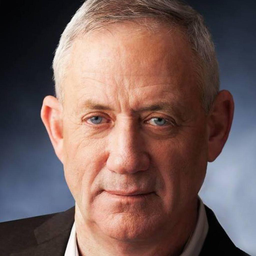
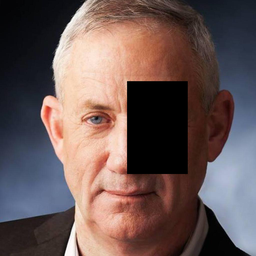
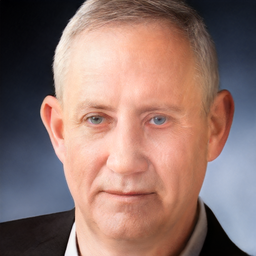
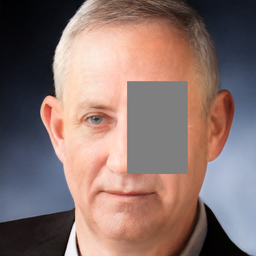

step 1081/1100: percep_loss 0.13 latent_dist_reg 0.17 loss 0.17 
step 1082/1100: percep_loss 0.13 latent_dist_reg 0.17 loss 0.17 
step 1083/1100: percep_loss 0.13 latent_dist_reg 0.17 loss 0.17 
step 1084/1100: percep_loss 0.13 latent_dist_reg 0.17 loss 0.17 
step 1085/1100: percep_loss 0.13 latent_dist_reg 0.17 loss 0.17 
step 1086/1100: percep_loss 0.13 latent_dist_reg 0.17 loss 0.17 
step 1087/1100: percep_loss 0.13 latent_dist_reg 0.17 loss 0.17 
step 1088/1100: percep_loss 0.13 latent_dist_reg 0.17 loss 0.17 
step 1089/1100: percep_loss 0.13 latent_dist_reg 0.17 loss 0.17 
step 1090/1100: percep_loss 0.13 latent_dist_reg 0.17 loss 0.17 
step 1091/1100: percep_loss 0.13 latent_dist_reg 0.17 loss 0.17 
step 1092/1100: percep_loss 0.13 latent_dist_reg 0.17 loss 0.17 
step 1093/1100: percep_loss 0.13 latent_dist_reg 0.17 loss 0.17 
step 1094/1100: percep_loss 0.13 latent_dist_reg 0.17 loss 0.17 
step 1095/1100: percep_loss 0.13 latent_dist_reg 0.17 loss 0.17 
step 1096/1100: percep_lo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:150: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


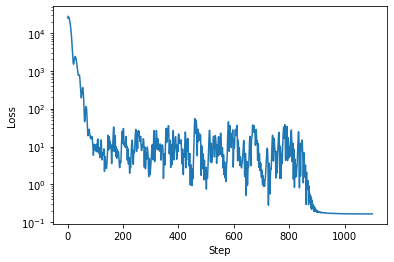

Elapsed: 809.2 s


In [22]:
invert_image(INPAINTING_DEGRADATION,
                   "/content/drive/MyDrive/ex5_impr/original/beni_output.jpeg",
                   "/content/drive/MyDrive/ex5_impr/beni_inpainting", num_steps=1100, latent_dist_reg_weight=0.2)

Original Image,Original Degraded Image,Generated Image,Generated Degraded Image

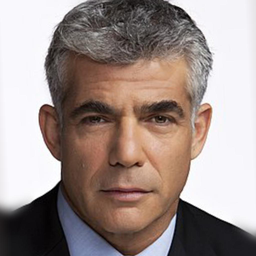
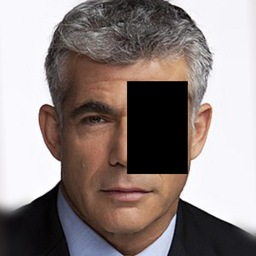
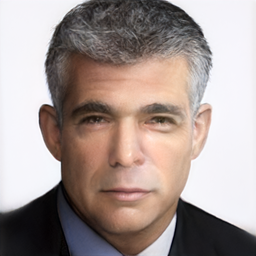
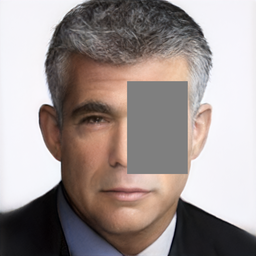

step 1081/1100: percep_loss 0.11 latent_dist_reg 0.24 loss 0.13 
step 1082/1100: percep_loss 0.11 latent_dist_reg 0.24 loss 0.13 
step 1083/1100: percep_loss 0.11 latent_dist_reg 0.24 loss 0.13 
step 1084/1100: percep_loss 0.11 latent_dist_reg 0.24 loss 0.13 
step 1085/1100: percep_loss 0.11 latent_dist_reg 0.24 loss 0.13 
step 1086/1100: percep_loss 0.11 latent_dist_reg 0.24 loss 0.13 
step 1087/1100: percep_loss 0.11 latent_dist_reg 0.24 loss 0.13 
step 1088/1100: percep_loss 0.11 latent_dist_reg 0.24 loss 0.13 
step 1089/1100: percep_loss 0.11 latent_dist_reg 0.24 loss 0.13 
step 1090/1100: percep_loss 0.11 latent_dist_reg 0.24 loss 0.13 
step 1091/1100: percep_loss 0.11 latent_dist_reg 0.24 loss 0.13 
step 1092/1100: percep_loss 0.11 latent_dist_reg 0.24 loss 0.13 
step 1093/1100: percep_loss 0.11 latent_dist_reg 0.24 loss 0.13 
step 1094/1100: percep_loss 0.11 latent_dist_reg 0.24 loss 0.13 
step 1095/1100: percep_loss 0.11 latent_dist_reg 0.24 loss 0.13 
step 1096/1100: percep_lo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:150: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


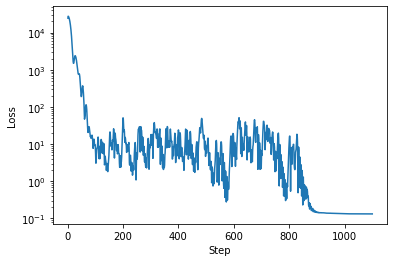

Elapsed: 797.9 s


In [21]:
invert_image(INPAINTING_DEGRADATION,
                   "/content/drive/MyDrive/ex5_impr/original/lapid_output.jpeg",
                   "/content/drive/MyDrive/ex5_impr/lapid_inpainting", num_steps=1100, latent_dist_reg_weight=0.1)